# Match predicter for national football

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#import
df = pd.read_csv('results.csv')
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [179]:
#filtering
rel_tournaments = [
    'FIFA World Cup',
    'UEFA Nations League',
    'UEFA Euro',
    'AFC Asian Cup',
    'African Cup of Nations',
    'Gold Cup',
    'Copa América',
    'Oceania Nations Cup'
]

df_filtered = df[df['tournament'].isin(rel_tournaments)].copy() #why copy?

df_filtered = df_filtered[['date','home_team','away_team','home_score','away_score','tournament']]

In [180]:
#print first lines
print(df_filtered.head())

           date  home_team away_team  home_score  away_score    tournament
478  1916-07-02      Chile   Uruguay           0           4  Copa América
480  1916-07-06  Argentina     Chile           6           1  Copa América
481  1916-07-08     Brazil     Chile           1           1  Copa América
482  1916-07-10  Argentina    Brazil           1           1  Copa América
484  1916-07-12     Brazil   Uruguay           1           2  Copa América


## create pred. var


In [181]:
def determineResult(row):
    if row['home_score'] > row['away_score']:
        return 'H'  # Home won
    elif row['home_score'] < row['away_score']:
        return 'A'  # Away won
    else:
        return 'D'  # tie

df_filtered['result'] = df_filtered.apply(determineResult, axis=1)

## Prepare train test data

In [182]:
#simple feature engineering
le = LabelEncoder()
all_teams = pd.concat([df_filtered['home_team'], df_filtered['away_team']]).unique()
le.fit(all_teams)

df_filtered['home_id'] = le.transform(df_filtered['home_team'])
df_filtered['away_id'] = le.transform(df_filtered['away_team'])

#create ids
tournament_encoder = LabelEncoder()
df_filtered['tournament_id'] = tournament_encoder.fit_transform(df_filtered['tournament'])

features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

df_filtered

,date,home_team,away_team,home_score,away_score,tournament,result,home_id,away_id,tournament_id
478,1916-07-02,Chile,Uruguay,0,4,Copa América,A,27,170,2
480,1916-07-06,Argentina,Chile,6,1,Copa América,H,4,27,2
481,1916-07-08,Brazil,Chile,1,1,Copa América,D,19,27,2
482,1916-07-10,Argentina,Brazil,1,1,Copa América,D,4,19,2
484,1916-07-12,Brazil,Uruguay,1,2,Copa América,A,19,170,2
...,...,...,...,...,...,...,...,...,...,...
48361,2025-06-29,Canada,Guatemala,1,1,Gold Cup,D,25,65,4
48362,2025-06-29,United States,Costa Rica,2,2,Gold Cup,D,169,33,4
48363,2025-07-02,United States,Guatemala,2,1,Gold Cup,H,169,65,4
48364,2025-07-02,Mexico,Honduras,1,0,Gold Cup,H,104,70,4


## train model:

In [183]:
#split data
X = df_filtered[features]
y = df_filtered[target]

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
#actual model training
model_RF = RandomForestClassifier(n_estimators=100, random_state=42,min_samples_split=2)

model_RF.fit(X_train, y_train)

In [188]:
import joblib
#save model
#joblib.dump(model_RF, 'random_forest_model.pkl')

## Now logistic regression model for prediction

In [189]:
#prepare data again:
features = ['home_id', 'away_id', 'tournament_id']
target = 'result'

X = df_filtered[features]
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [190]:
#create model:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_log = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # WICHTIG: Gleicht unausgeglichene Klassen aus
)

model_log.fit(X_train_scaled, y_train)

/home/yasou/PycharmProjects/MatchPredictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'multinomial'


## evaluation of the models

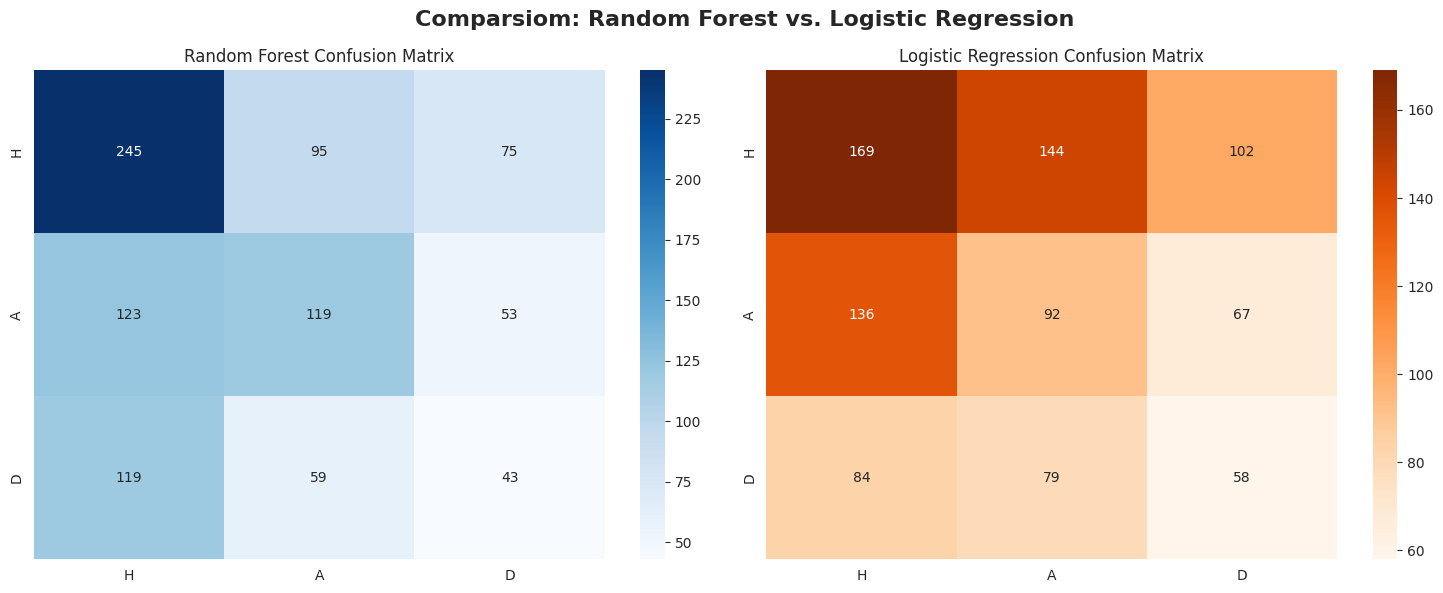

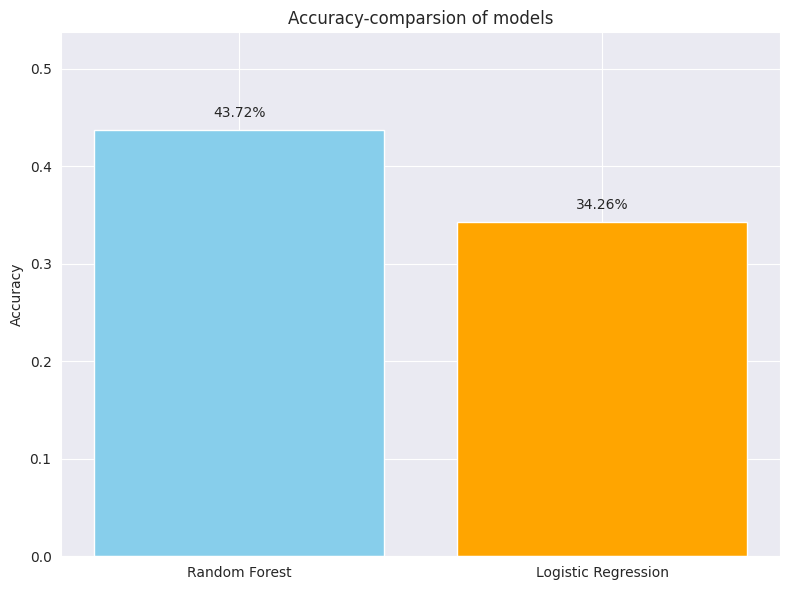

In [195]:
y_pred_rf = model_RF.predict(X_test)
y_pred_log = model_log.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
acc_log = accuracy_score(y_test, y_pred_log)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparsiom: Random Forest vs. Logistic Regression', fontsize=16, fontweight='bold')

#Confusion Matrix of Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['H', 'A', 'D'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[0].set_title('Random Forest Confusion Matrix')

#Confusion Matrix of Logistic regression
cm_log = confusion_matrix(y_test, y_pred_log, labels=['H', 'A', 'D'])
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
           xticklabels=['H', 'A', 'D'], yticklabels=['H', 'A', 'D'])
axes[1].set_title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.show()

#evaluate accuary
plt.figure(figsize=(8, 6))
models = ['Random Forest', 'Logistic Regression']
accuracies = [acc_rf, acc_log]

bars = plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.title('Accuracy-comparsion of models')
plt.ylabel('Accuracy')
plt.ylim(0, max(accuracies) + 0.1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [197]:
print('Classification Reports:')
print('Random forest:')
print(classification_report(y_test, y_pred_rf, zero_division=0))
print('logistic regression:')
print(classification_report(y_test, y_pred_log, zero_division=0))

Classification Reports:
Random forest:
              precision    recall  f1-score   support

           A       0.44      0.40      0.42       295
           D       0.25      0.19      0.22       221
           H       0.50      0.59      0.54       415

    accuracy                           0.44       931
   macro avg       0.40      0.40      0.39       931
weighted avg       0.42      0.44      0.43       931

logistic regression:
              precision    recall  f1-score   support

           A       0.29      0.31      0.30       295
           D       0.26      0.26      0.26       221
           H       0.43      0.41      0.42       415

    accuracy                           0.34       931
   macro avg       0.33      0.33      0.33       931
weighted avg       0.35      0.34      0.34       931

